In [1]:
import tensorflow as tf
import json
import numpy as np
import cv2

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from auxiliary.data.dataset_cell import CellDataset
from auxiliary import values as v
from auxiliary.utils.colors import bcolors as c

# from focal_loss import SparseCategoricalFocalLoss
from tensorflow.keras.losses import CategoricalCrossentropy
from cell_division.nets.custom_layers import (
    w_cel_loss, 
    focal_loss,
    ExtendedLSEPooling,
    extended_w_cel_loss
)

from sklearn.utils.class_weight import compute_class_weight

# GPU config
from auxiliary.utils.timer import LoadingBar
from auxiliary.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator, 
    clear_session
)

increase_gpu_memory()
set_gpu_allocator()

In [2]:
img_dir = v.data_path + 'CellDivision/images/'
label_train_dir = v.data_path + 'CellDivision/train.csv'
label_test_dir = v.data_path + 'CellDivision/test.csv'
label_val_dir = v.data_path + 'CellDivision/val.csv'

INPUT_SHAPE = (50, 50, 3)
BATCH_SIZE = 32

Dataset (Generators)

Generatos do not load directly the images into memory, but they load the images on the fly. This is useful when the dataset is too large to fit into memory.

In [3]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir, 
    batch_size=BATCH_SIZE, 
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir, 
    batch_size=BATCH_SIZE, 
    resize=INPUT_SHAPE[:2]
)

Transfer Learning 

In [4]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer, np.int64, np.int32, np.int16, np.int8)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32, np.float16)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)): 
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

In [5]:
base_models = {
    'DenseNet121': tf.keras.applications.DenseNet121,
    'EfficientNetV2L': tf.keras.applications.EfficientNetV2L,
    'EfficientNetV2M': tf.keras.applications.EfficientNetV2M,
    'VGG16': tf.keras.applications.VGG16,
    'ResNet50': tf.keras.applications.ResNet50,
    'InceptionV3': tf.keras.applications.InceptionV3,
    'MobileNetV2': tf.keras.applications.MobileNetV2,
    'NASNetMobile': tf.keras.applications.NASNetMobile,
}


In [6]:
param_grid = {
    'base_model': list(base_models.keys()),
    'lr': [1e-3, 1e-2],
    # 'fine_tune': [True, False],
    'loss': [focal_loss(), w_cel_loss(), extended_w_cel_loss()],
    'top': ['CAM', 'Standard'],
    # 'class_weight': [None, 'balanced']
}

In [7]:
bar = LoadingBar(
    len(param_grid['base_model']) * len(param_grid['lr']) * len(param_grid['loss']) * len(param_grid['top'])
)

results = {}

for base_model in param_grid['base_model']:
    for lr in param_grid['lr']:
        for loss in param_grid['loss']:
            for top in param_grid['top']:
                print(f'\n{c.OKGREEN}Model: {base_model} - LR: {lr} - Loss: {loss} - Top: {top}{c.ENDC}')
                
                try:
                    model = CNN(
                        base=base_models[base_model],
                        n_classes=3,
                        input_shape=INPUT_SHAPE
                    )
                    model.build_top(activation='softmax', b_type=top)
                    model.compile(lr=lr, loss=loss)
                    model.fit(
                        train_generator,
                        val_generator,
                        epochs=100,
                        batch_size=BATCH_SIZE,
                        save=False,
                        verbose=1
                    )

                    results[
                        str((base_model, lr, loss.__name__, top))
                    ] = model.model.history.history
                except Exception as e:
                    print(f'{c.FAIL}Error:{c.ENDC} {e}')
                    results[str((base_model, lr, loss.__name__, top))] = None

                clear_session()
                bar.update()
                    
    with open(f'../cell_division/results/{base_model}.json', 'w') as f:
        json.dump(results, f, cls=NumpyEncoder)
    results = {}

bar.end()


Model: DenseNet121 - LR: 0.001 - Loss: <function focal_loss.<locals>.focal_loss_fixed at 0x732900deca60> - Top: CAM
Shape after transition layer: (None, 1, 1, 1024)
Shape after pooling layer: (None, 1024)
Epoch 1/100
96/96 [==============================] - 22s 159ms/step - loss: 0.2658 - auc: 0.6844 - val_loss: 0.1032 - val_auc: 0.7168 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 11s 118ms/step - loss: 0.1980 - auc: 0.7567 - val_loss: 0.1166 - val_auc: 0.7399 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 12s 123ms/step - loss: 0.1426 - auc: 0.7955 - val_loss: 0.1809 - val_auc: 0.7783 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - ETA: 0s - loss: 0.1335 - auc: 0.8275
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
96/96 [==============================] - 11s 116ms/step - loss: 0.1335 - auc: 0.8275 - val_loss: 0.0987 - val_auc: 0.7952 - lr: 0.0010
Epoch 5/100
96/96 [==============================] 

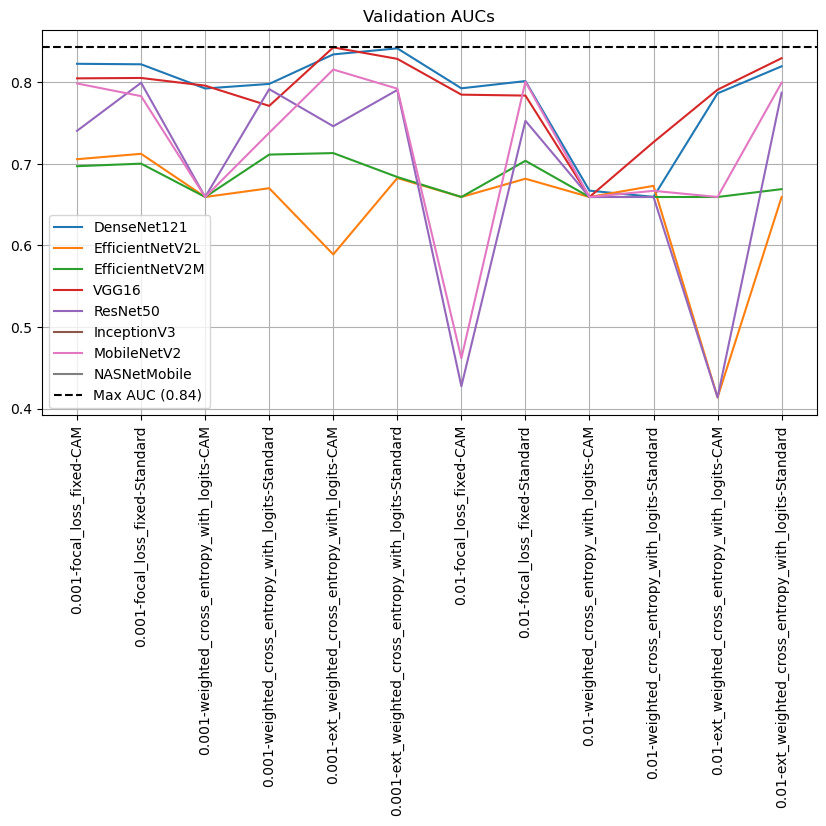

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

max_auc = 0
for base_model in param_grid['base_model']:
    try:
        with open(f'../cell_division/results/{base_model}.json', 'r') as f:
            results = json.load(f)
        
            val_aucs = [
                max(value['val_auc']) 
                for value in results.values() 
                if value is not None
            ]
            plt.plot(val_aucs, label=base_model)
            max_auc = max(max_auc, max(val_aucs))
    except:
        pass
    
plt.axhline(max_auc, color='black', linestyle='--', label=f'Max AUC ({max_auc:.2f})')

x_ticks = []
for lr in param_grid['lr']:
    for loss in param_grid['loss']:
        for top in param_grid['top']:
            x_ticks.append(f'{lr}-{loss.__name__}-{top}')
            
plt.xticks(range(len(x_ticks)), x_ticks, rotation=90)
    
plt.title('Validation AUCs')
plt.legend()
plt.grid()
plt.show()

Epoch 1/100
24/24 [==============================] - 14s 513ms/step - loss: 2.1392 - auc: 0.6624 - val_loss: 1.7075 - val_auc: 0.7376 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 11s 469ms/step - loss: 1.4046 - auc: 0.7896 - val_loss: 1.9222 - val_auc: 0.7852 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 11s 481ms/step - loss: 1.1326 - auc: 0.8627 - val_loss: 1.9286 - val_auc: 0.8007 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 1.0062 - auc: 0.8780
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
24/24 [==============================] - 11s 464ms/step - loss: 1.0062 - auc: 0.8780 - val_loss: 1.8908 - val_auc: 0.7960 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - 11s 476ms/step - loss: 0.9185 - auc: 0.8945 - val_loss: 1.7369 - val_auc: 0.8017 - lr: 1.0000e-04
Epoch 6/100
24/24 [==============================] - 11s 466ms/step - loss: 0.9773 - auc: 0.8763 - val_los

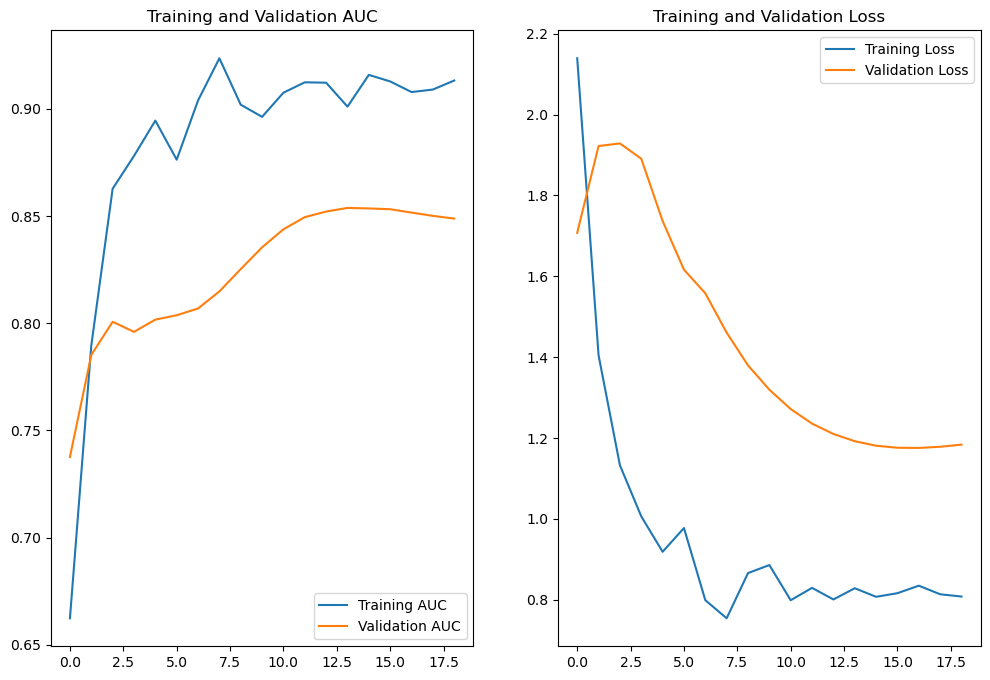

In [8]:
model = CNN(
    base=base_models['VGG16'],
    n_classes=3,
    input_shape=INPUT_SHAPE
)
model.build_top(activation='softmax', b_type='CAM')
model.compile(lr=.001, loss=extended_w_cel_loss())
model.fit(
    train_generator,
    val_generator,
    epochs=100,
    batch_size=BATCH_SIZE,
    save=True,
    verbose=2
)

Class activation mapping

ValueError: could not broadcast input array from shape (50,50,3) into shape (1,)

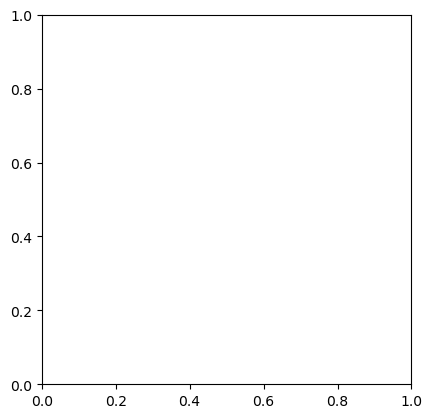

In [11]:
test_generator = CellDataset(
    img_dir, 
    label_test_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

test_img = test_generator[0]
plt.imshow(test_img)